# **Table of Contents**
### 1) Data preprocessing
### 2) Visualizations
### 3) Balancing the data (Oversampling)
### 4) The BERT Model training
### 5) Saving the processed data

In [1]:
!pip install contractions

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 4.7 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.7/110.7 kB 7.4 MB/s eta 0:00:00


# **Imports**

In [2]:
import pandas as pd
import pandas as pd
import numpy as np 

import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import contractions

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder

from sklearn.metrics import roc_auc_score, confusion_matrix
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

In [3]:
recomend_data = pd.read_csv('/kaggle/input/review-processed-dataset/processed_data.csv')
recomend_data.head(2)

<ipython-input-3-c0ae73342476>:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  recomend_data = pd.read_csv('/kaggle/input/review-processed-dataset/processed_data.csv')


,author_id,skin_type,rating,review_text,total_feedback_count,total_neg_feedback_count,total_pos_feedback_count,product_id,price_usd,product_name,...,has__caprylyl_glycol_,has__potassium_sorbate_,has__polysorbate_,has__sodium_hydroxide_,has__capryliccapric_triglyceride_,has__tocopheryl_acetate_,has__squalane_,has__dimethicone_,has__pentylene_glycol_,has_water_
0,1741593524,dry,5,I use this with the Nudestix “Citrus Clean Bal...,2,0,2,P504322,19.0,Gentle Hydra-Gel Face Cleanser,...,0,0,0,0,0,0,0,0,0,1
1,5061282401,dry,5,My review title says it all! I get so excited ...,0,0,0,P420652,24.0,Lip Sleeping Mask Intense Hydration with Vitam...,...,0,0,0,0,0,0,0,0,0,1


---------------------------------------------------------------------------------
# **1) Data Preprocessing**
# Label Encoding

In [4]:
recomend_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 863473 entries, 0 to 863472
Data columns (total 38 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   author_id                          863473 non-null  object 
 1   skin_type                          863473 non-null  object 
 2   rating                             863473 non-null  int64  
 3   review_text                        863473 non-null  object 
 4   total_feedback_count               863473 non-null  int64  
 5   total_neg_feedback_count           863473 non-null  int64  
 6   total_pos_feedback_count           863473 non-null  int64  
 7   product_id                         863473 non-null  object 
 8   price_usd                          863473 non-null  float64
 9   product_name                       863473 non-null  object 
 10  ingredients                        863473 non-null  object 
 11  highlights                         8634

### **1) Onehot encoding for the skin types**

In [5]:
# Creating a copy of the dataframe
encoded_data = recomend_data.copy()

# Initializing the OneHotEncoder
encoder = OneHotEncoder(sparse=False)  # sparse=False to get a dense array instead of sparse matrix

# Fiting and transforming the skin_type column
# The reshaping is needed because the One Hot Encoder expects a 2D array
skin_type_encoded = encoder.fit_transform(encoded_data[['skin_type']])

# Creating a dataframe with the encoded values
skin_type_encoded_df = pd.DataFrame(
    skin_type_encoded,
    columns=encoder.get_feature_names_out(['skin_type']),
    index=encoded_data.index
)

# Adding the encoded columns to the original dataframe
encoded_data = pd.concat([encoded_data, skin_type_encoded_df], axis=1)

# Verifying the encoding
encoded_data.head()

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,author_id,skin_type,rating,review_text,total_feedback_count,total_neg_feedback_count,total_pos_feedback_count,product_id,price_usd,product_name,...,has__capryliccapric_triglyceride_,has__tocopheryl_acetate_,has__squalane_,has__dimethicone_,has__pentylene_glycol_,has_water_,skin_type_combination,skin_type_dry,skin_type_normal,skin_type_oily
0,1741593524,dry,5,I use this with the Nudestix “Citrus Clean Bal...,2,0,2,P504322,19.0,Gentle Hydra-Gel Face Cleanser,...,0,0,0,0,0,1,0.0,1.0,0.0,0.0
1,5061282401,dry,5,My review title says it all! I get so excited ...,0,0,0,P420652,24.0,Lip Sleeping Mask Intense Hydration with Vitam...,...,0,0,0,0,0,1,0.0,1.0,0.0,0.0
2,6083038851,combination,5,I’ve always loved this formula for a long time...,0,0,0,P420652,24.0,Lip Sleeping Mask Intense Hydration with Vitam...,...,0,0,0,0,0,1,1.0,0.0,0.0,0.0
3,47056667835,combination,5,"If you have dry cracked lips, this is a must h...",0,0,0,P420652,24.0,Lip Sleeping Mask Intense Hydration with Vitam...,...,0,0,0,0,0,1,1.0,0.0,0.0,0.0
4,42802569154,normal,4,The scent isn’t my favourite but it works grea...,1,0,1,P420652,24.0,Lip Sleeping Mask Intense Hydration with Vitam...,...,0,0,0,0,0,1,0.0,0.0,1.0,0.0


In [6]:
encoded_data.shape

(863473, 42)

In [7]:
encoded_data.columns

Index(['author_id', 'skin_type', 'rating', 'review_text',
       'total_feedback_count', 'total_neg_feedback_count',
       'total_pos_feedback_count', 'product_id', 'price_usd', 'product_name',
       'ingredients', 'highlights', 'primary_category', 'secondary_category',
       'processed_review', 'review_length', 'processed_ingredients',
       'ingredient_count', 'has__glycerin_', 'has__phenoxyethanol_',
       'has__butylene_glycol_', 'has__propanediol_', 'has__tocopherol_',
       'has__citric_acid_', 'has__ethylhexylglycerin_',
       'has__sodium_hyaluronate_', 'has__xanthan_gum_',
       'has__sodium_benzoate_', 'has__caprylyl_glycol_',
       'has__potassium_sorbate_', 'has__polysorbate_',
       'has__sodium_hydroxide_', 'has__capryliccapric_triglyceride_',
       'has__tocopheryl_acetate_', 'has__squalane_', 'has__dimethicone_',
       'has__pentylene_glycol_', 'has_water_', 'skin_type_combination',
       'skin_type_dry', 'skin_type_normal', 'skin_type_oily'],
      dtype='

In [8]:
encoded_data.drop(columns = "skin_type", inplace= True)
encoded_data.columns

Index(['author_id', 'rating', 'review_text', 'total_feedback_count',
       'total_neg_feedback_count', 'total_pos_feedback_count', 'product_id',
       'price_usd', 'product_name', 'ingredients', 'highlights',
       'primary_category', 'secondary_category', 'processed_review',
       'review_length', 'processed_ingredients', 'ingredient_count',
       'has__glycerin_', 'has__phenoxyethanol_', 'has__butylene_glycol_',
       'has__propanediol_', 'has__tocopherol_', 'has__citric_acid_',
       'has__ethylhexylglycerin_', 'has__sodium_hyaluronate_',
       'has__xanthan_gum_', 'has__sodium_benzoate_', 'has__caprylyl_glycol_',
       'has__potassium_sorbate_', 'has__polysorbate_',
       'has__sodium_hydroxide_', 'has__capryliccapric_triglyceride_',
       'has__tocopheryl_acetate_', 'has__squalane_', 'has__dimethicone_',
       'has__pentylene_glycol_', 'has_water_', 'skin_type_combination',
       'skin_type_dry', 'skin_type_normal', 'skin_type_oily'],
      dtype='object')

In [11]:
encoded_data['secondary_category'].unique()

array(['Cleansers', 'Lip Balms & Treatments', 'Moisturizers',
       'Treatments', 'Mini Size', 'Masks', 'Sunscreen', 'Self Tanners',
       'Eye Care', 'Wellness'], dtype=object)

<font size = "20" color = "green">============================</font>

## But the 'Mini Size' category doesn't represent any product type, so I will need to handel it

# First lets take copy of the recomend_data to handle the mini size category

In [12]:
mini_test_df = encoded_data.copy()

In [13]:
mini_test_df.columns

Index(['rating', 'review_text', 'total_feedback_count',
       'total_neg_feedback_count', 'total_pos_feedback_count', 'product_id',
       'price_usd', 'product_name', 'ingredients', 'highlights',
       'primary_category', 'secondary_category', 'processed_review',
       'review_length', 'processed_ingredients', 'ingredient_count',
       'has__glycerin_', 'has__phenoxyethanol_', 'has__butylene_glycol_',
       'has__propanediol_', 'has__tocopherol_', 'has__citric_acid_',
       'has__ethylhexylglycerin_', 'has__sodium_hyaluronate_',
       'has__xanthan_gum_', 'has__sodium_benzoate_', 'has__caprylyl_glycol_',
       'has__potassium_sorbate_', 'has__polysorbate_',
       'has__sodium_hydroxide_', 'has__capryliccapric_triglyceride_',
       'has__tocopheryl_acetate_', 'has__squalane_', 'has__dimethicone_',
       'has__pentylene_glycol_', 'has_water_', 'skin_type_combination',
       'skin_type_dry', 'skin_type_normal', 'skin_type_oily'],
      dtype='object')

In [14]:
mini_test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 863473 entries, 0 to 863472
Data columns (total 40 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   rating                             863473 non-null  int64  
 1   review_text                        863473 non-null  object 
 2   total_feedback_count               863473 non-null  int64  
 3   total_neg_feedback_count           863473 non-null  int64  
 4   total_pos_feedback_count           863473 non-null  int64  
 5   product_id                         863473 non-null  object 
 6   price_usd                          863473 non-null  float64
 7   product_name                       863473 non-null  object 
 8   ingredients                        863473 non-null  object 
 9   highlights                         863473 non-null  object 
 10  primary_category                   863473 non-null  object 
 11  secondary_category                 8634

### I can handle this by finding products labeled as "Mini Size" and checking if there are products with the same product_name but a different secondary_category. If a match is found, update the "Mini Size" category with the corresponding category.

In [15]:
# Counting the rows where the secondary_category is 'Mini Size'
mini_size_count = len(mini_test_df[mini_test_df['secondary_category'] == 'Mini Size'])
print(f"Number of rows with 'Mini Size' category: {mini_size_count}")

# Calculating their percentage of the total rows
total_rows = len(mini_test_df)
percentage = (mini_size_count / total_rows) * 100
print(f"Percentage of 'Mini Size' rows: {percentage:.2f}%")

Number of rows with 'Mini Size' category: 77852
Percentage of 'Mini Size' rows: 9.02%


In [16]:
# Creating a mapping of product names to their most common category (but I will exclude the Mini Size)
category_mapping = (
    mini_test_df[mini_test_df['secondary_category'] != 'Mini Size']
    .groupby('product_name')['secondary_category']
    .agg(lambda x: x.mode()[0] if not x.empty else None)
    .to_dict()
)

# Replacing the Mini Size categories with the corresponding ones
mini_size_mask = mini_test_df['secondary_category'] == 'Mini Size'
mini_test_df.loc[mini_size_mask, 'secondary_category'] = (
    mini_test_df.loc[mini_size_mask, 'product_name']
    .map(lambda x: category_mapping.get(x, 'Mini Size'))
)

# Checking the results
print("Updated category distribution:")
print(mini_test_df['secondary_category'].value_counts())

# Checking how many Mini Size items remaind
remaining_mini = (mini_test_df['secondary_category'] == 'Mini Size').sum()
print(f"\nRemaining Mini Size items: {remaining_mini}")
print(f"Percentage of remaining Mini Size items: {(remaining_mini/len(mini_test_df))*100:.2f}%")

Updated category distribution:
secondary_category
Moisturizers              229173
Treatments                192003
Cleansers                 160834
Mini Size                  76726
Eye Care                   56315
Masks                      49645
Lip Balms & Treatments     46004
Sunscreen                  34835
Self Tanners               10820
Wellness                    7118
Name: count, dtype: int64

Remaining Mini Size items: 76726
Percentage of remaining Mini Size items: 8.89%


In [17]:
77852-76726

1126

<font size = "5" color = "yellow"><b>Only <font color = "red">1126</font> products out of <font color = "red">77852</font> products are changed from mini size to another category (still there <font color = "red">76726</font> products with Mini Size category)</b></font> 

In [18]:
mini_test_df.columns

Index(['rating', 'review_text', 'total_feedback_count',
       'total_neg_feedback_count', 'total_pos_feedback_count', 'product_id',
       'price_usd', 'product_name', 'ingredients', 'highlights',
       'primary_category', 'secondary_category', 'processed_review',
       'review_length', 'processed_ingredients', 'ingredient_count',
       'has__glycerin_', 'has__phenoxyethanol_', 'has__butylene_glycol_',
       'has__propanediol_', 'has__tocopherol_', 'has__citric_acid_',
       'has__ethylhexylglycerin_', 'has__sodium_hyaluronate_',
       'has__xanthan_gum_', 'has__sodium_benzoate_', 'has__caprylyl_glycol_',
       'has__potassium_sorbate_', 'has__polysorbate_',
       'has__sodium_hydroxide_', 'has__capryliccapric_triglyceride_',
       'has__tocopheryl_acetate_', 'has__squalane_', 'has__dimethicone_',
       'has__pentylene_glycol_', 'has_water_', 'skin_type_combination',
       'skin_type_dry', 'skin_type_normal', 'skin_type_oily'],
      dtype='object')

In [19]:
mini_test_df["secondary_category"].unique()

array(['Cleansers', 'Lip Balms & Treatments', 'Moisturizers',
       'Treatments', 'Mini Size', 'Masks', 'Sunscreen', 'Self Tanners',
       'Eye Care', 'Wellness'], dtype=object)

In [12]:
encoded_data.columns

Index(['rating', 'review_text', 'total_feedback_count',
       'total_neg_feedback_count', 'total_pos_feedback_count', 'product_id',
       'price_usd', 'product_name', 'ingredients', 'highlights',
       'primary_category', 'secondary_category', 'processed_review',
       'review_length', 'processed_ingredients', 'ingredient_count',
       'has__glycerin_', 'has__phenoxyethanol_', 'has__butylene_glycol_',
       'has__propanediol_', 'has__tocopherol_', 'has__citric_acid_',
       'has__ethylhexylglycerin_', 'has__sodium_hyaluronate_',
       'has__xanthan_gum_', 'has__sodium_benzoate_', 'has__caprylyl_glycol_',
       'has__potassium_sorbate_', 'has__polysorbate_',
       'has__sodium_hydroxide_', 'has__capryliccapric_triglyceride_',
       'has__tocopheryl_acetate_', 'has__squalane_', 'has__dimethicone_',
       'has__pentylene_glycol_', 'has_water_', 'skin_type_combination',
       'skin_type_dry', 'skin_type_normal', 'skin_type_oily'],
      dtype='object')

# Now Lets take a Copy of the "encoded_data" data frame

In [13]:
final_df = encoded_data.copy()
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 863473 entries, 0 to 863472
Data columns (total 40 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   rating                             863473 non-null  int64  
 1   review_text                        863473 non-null  object 
 2   total_feedback_count               863473 non-null  int64  
 3   total_neg_feedback_count           863473 non-null  int64  
 4   total_pos_feedback_count           863473 non-null  int64  
 5   product_id                         863473 non-null  object 
 6   price_usd                          863473 non-null  float64
 7   product_name                       863473 non-null  object 
 8   ingredients                        863473 non-null  object 
 9   highlights                         863473 non-null  object 
 10  primary_category                   863473 non-null  object 
 11  secondary_category                 8634

## **Dropping the rows where  the "secondary_category" = "Mini Size"**

In [14]:
# Droping the rows where 'secondary_category' is 'Mini Size'
final_df = final_df[final_df['secondary_category'] != 'Mini Size']

# Reseting the index after dropping the rows
final_df.reset_index(drop=True, inplace=True)

# Printing the shape to see how many rows remaind
print(f"Shape after dropping Mini Size rows: {final_df.shape}")

# Printing the unique values in the secondary_category to confirm that the "Mini Size" is droped
print("\nUnique values in secondary_category:")
print(final_df['secondary_category'].unique())

Shape after dropping Mini Size rows: (785621, 40)

Unique values in secondary_category:
['Cleansers' 'Lip Balms & Treatments' 'Moisturizers' 'Treatments' 'Masks'
 'Sunscreen' 'Self Tanners' 'Eye Care' 'Wellness']


In [15]:
final_df.shape

(785621, 40)

In [16]:
pd.set_option("display.max_columns", None)

In [17]:
final_df.head(2)

,rating,review_text,total_feedback_count,total_neg_feedback_count,total_pos_feedback_count,product_id,price_usd,product_name,ingredients,highlights,primary_category,secondary_category,processed_review,review_length,processed_ingredients,ingredient_count,has__glycerin_,has__phenoxyethanol_,has__butylene_glycol_,has__propanediol_,has__tocopherol_,has__citric_acid_,has__ethylhexylglycerin_,has__sodium_hyaluronate_,has__xanthan_gum_,has__sodium_benzoate_,has__caprylyl_glycol_,has__potassium_sorbate_,has__polysorbate_,has__sodium_hydroxide_,has__capryliccapric_triglyceride_,has__tocopheryl_acetate_,has__squalane_,has__dimethicone_,has__pentylene_glycol_,has_water_,skin_type_combination,skin_type_dry,skin_type_normal,skin_type_oily
0,5,I use this with the Nudestix “Citrus Clean Bal...,2,0,2,P504322,19.0,Gentle Hydra-Gel Face Cleanser,"['Water (Aqua), Dipropylene Glycol, Peg-6 Capr...",['Clean at Sephora'],Skincare,Cleansers,use nudestix citrus clean balm makeup melt dou...,283,water | dipropylene glycol | peg capryliccapri...,22,1,0,1,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0.0,1.0,0.0,0.0
1,5,My review title says it all! I get so excited ...,0,0,0,P420652,24.0,Lip Sleeping Mask Intense Hydration with Vitam...,"['Diisostearyl Malate, Hydrogenated Polyisobut...","['allure 2019 Best of Beauty Award Winner', 'C...",Skincare,Lip Balms & Treatments,review title say get excited get bed apply lip...,178,diisostearyl malate | hydrogenated polyisobute...,34,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0.0,1.0,0.0,0.0


In [18]:
final_df.shape

(785621, 40)

In [19]:
final_df = final_df.drop(columns="highlights")
final_df.shape

(785621, 39)

# **2) Visualizations**

#### visualizing the ratings distribution across the different products categories

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


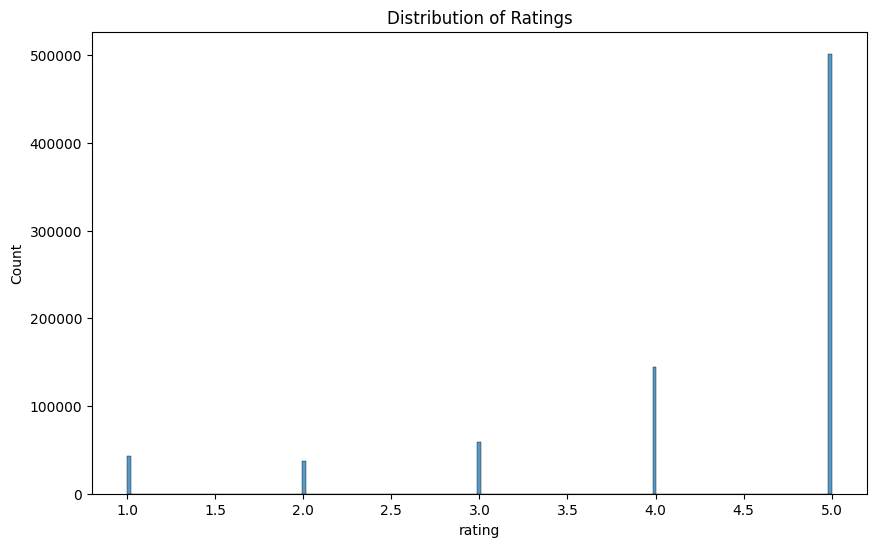

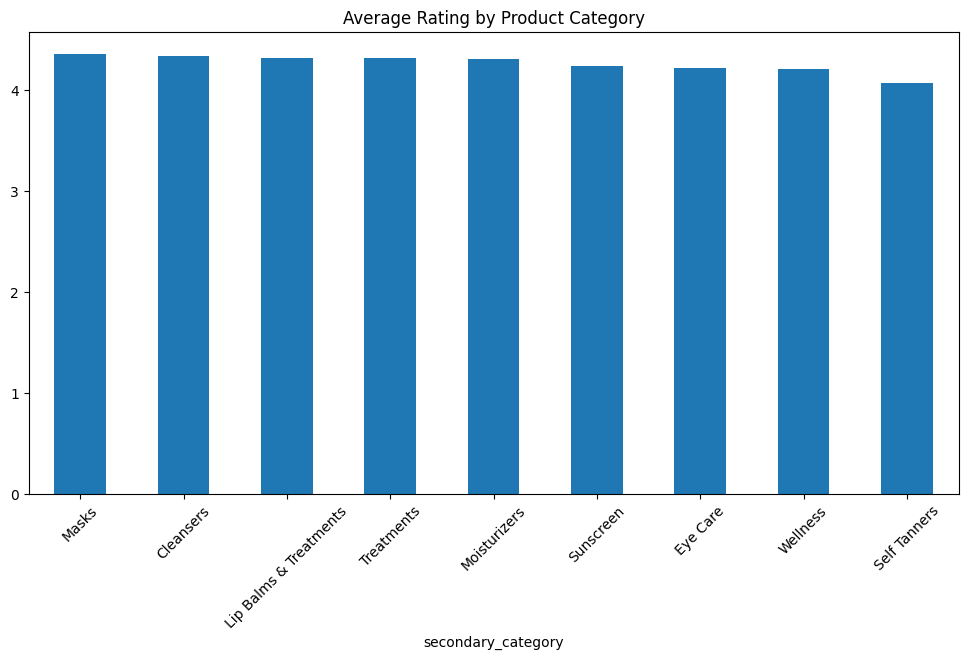

In [30]:
# The rating distribution
plt.figure(figsize=(10, 6))
sns.histplot(data=final_df, x='rating')
plt.title('Distribution of Ratings')
plt.show()

# The Average Rating of each Category
avg_ratings = final_df.groupby('secondary_category')['rating'].mean().sort_values(ascending=False)
plt.figure(figsize=(12, 6))
avg_ratings.plot(kind='bar')
plt.title('Average Rating by Product Category')
plt.xticks(rotation=45)
plt.show()

# **Observation**
### This visualization shows that almost all the categories have products with high ratings which means that there will be a good amount of products that has high ratings for the recommendation

# Lets visualize the ratings Counts in the dataset

Rating Counts:
rating
1     42525
2     37481
3     59200
4    144636
5    501779
Name: count, dtype: int64


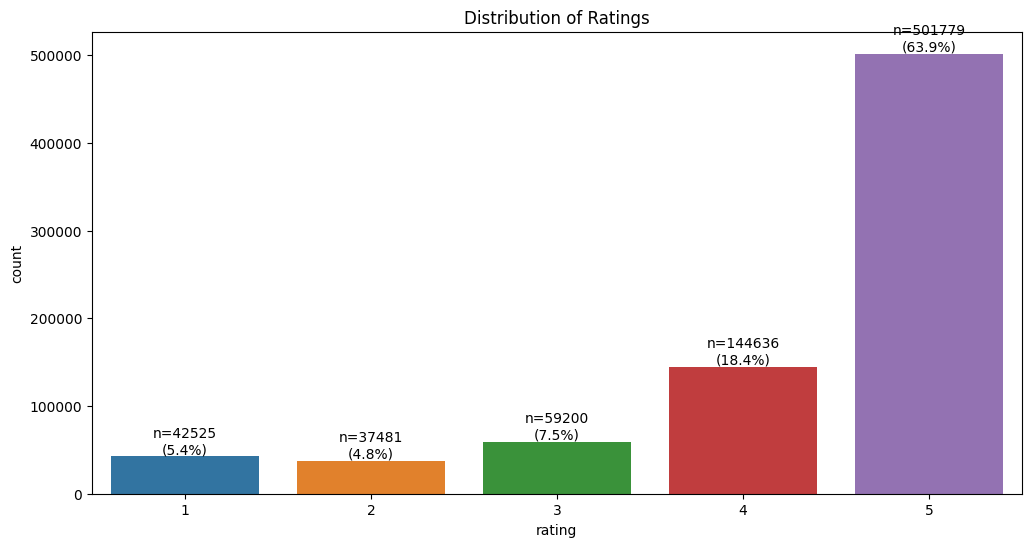


Rating Analysis:
         Count  Percentage
rating                    
1        42525    5.412915
2        37481    4.770876
3        59200    7.535440
4       144636   18.410404
5       501779   63.870365


In [31]:
# The Ratings counts
rating_counts = final_df['rating'].value_counts().sort_index()
print("Rating Counts:")
print(rating_counts)

# Plotting both their counts and percentages
plt.figure(figsize=(12, 6))
sns.countplot(data=final_df, x='rating')
plt.title('Distribution of Ratings')

# Adding the counts labels on the top of each bar
for i in range(len(rating_counts)):
    count = rating_counts[i+1]  # ratings are 1-5
    percentage = (count/len(final_df))*100
    plt.text(i, count, f'n={count}\n({percentage:.1f}%)',
             ha='center', va='bottom')

plt.show()

# Creating a table of the counts and percentages
rating_analysis = pd.DataFrame({
    'Count': rating_counts,
    'Percentage': (rating_counts/len(final_df))*100
})
print("\nRating Analysis:")
print(rating_analysis)

# **Observation**
### The plot shows that most of the products have a high ratings whish means that there is a strong imbalance in the dataset

# **Visualizing the most common ingredients**

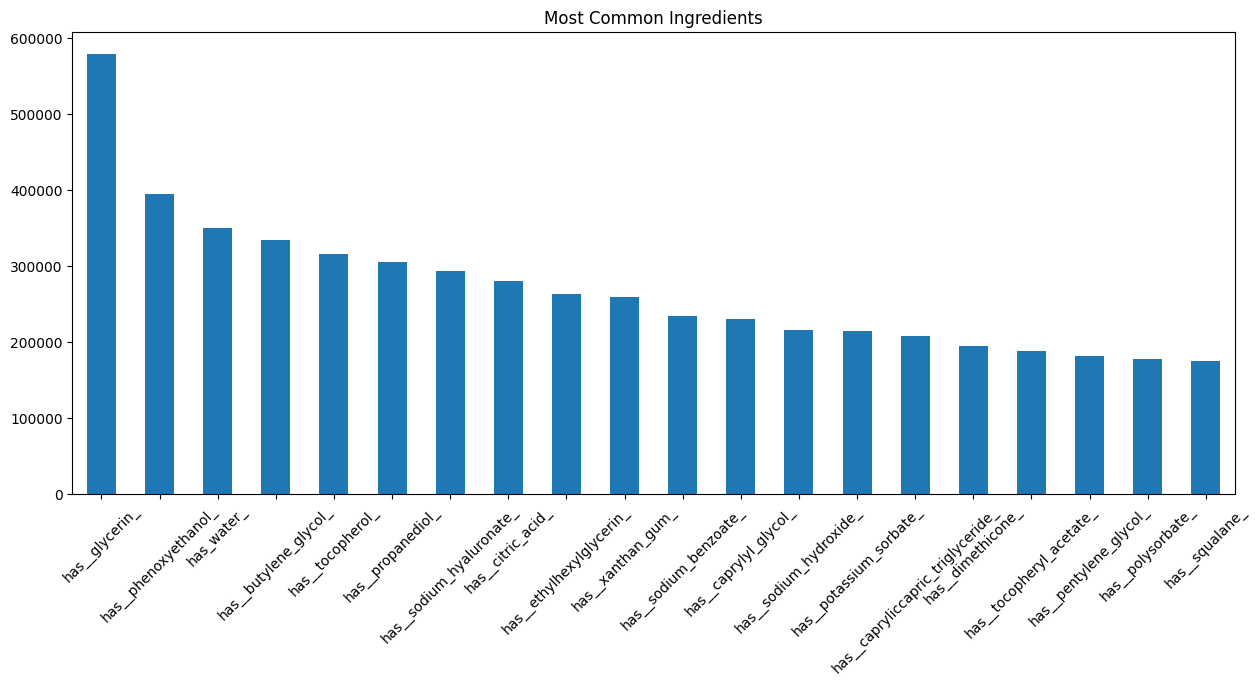

In [33]:
# Plotting the most Common Ingredients
ingredient_cols = [col for col in final_df.columns if col.startswith('has_')]
ingredient_sums = final_df[ingredient_cols].sum().sort_values(ascending=False)

plt.figure(figsize=(15, 6))
ingredient_sums.plot(kind='bar')
plt.title('Most Common Ingredients')
plt.xticks(rotation=45)
plt.show()

### I want to know  and plot the count of products who had a good (high) rating by each skin type

High Rating Counts by Skin Type (Ratings 4-5):
Combination:
  Count: 360200
  Total Reviews: 435240
  Percentage: 82.8%

Dry:
  Count: 122071
  Total Reviews: 149246
  Percentage: 81.8%

Normal:
  Count: 86521
  Total Reviews: 105802
  Percentage: 81.8%

Oily:
  Count: 77623
  Total Reviews: 95333
  Percentage: 81.4%



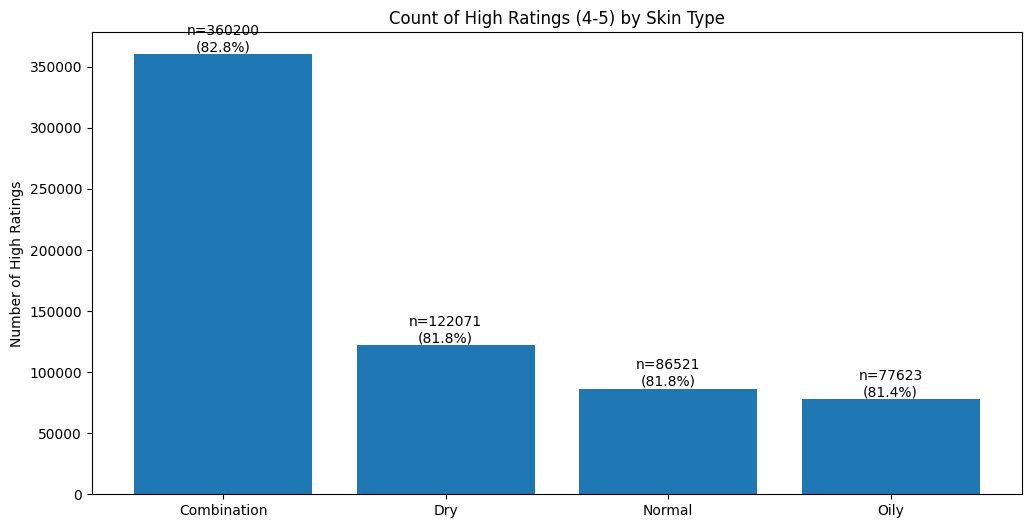

In [34]:
# Assuming that (4 and 5) are the high ratings
high_ratings = [4, 5]

# Calculating the counts of the ratings per each skin type
high_rating_counts = {
    'Combination': len(final_df[(final_df['skin_type_combination'] == 1) & (final_df['rating'].isin(high_ratings))]),
    'Dry': len(final_df[(final_df['skin_type_dry'] == 1) & (final_df['rating'].isin(high_ratings))]),
    'Normal': len(final_df[(final_df['skin_type_normal'] == 1) & (final_df['rating'].isin(high_ratings))]),
    'Oily': len(final_df[(final_df['skin_type_oily'] == 1) & (final_df['rating'].isin(high_ratings))])
}

# Calculating the total reviews for each skin type for calculating the percentage of the high ratings
total_counts = {
    'Combination': len(final_df[final_df['skin_type_combination'] == 1]),
    'Dry': len(final_df[final_df['skin_type_dry'] == 1]),
    'Normal': len(final_df[final_df['skin_type_normal'] == 1]),
    'Oily': len(final_df[final_df['skin_type_oily'] == 1])
}

# Printing the counts and the percentages of the ratings
print("High Rating Counts by Skin Type (Ratings 4-5):")
for skin_type in high_rating_counts:
    count = high_rating_counts[skin_type]
    total = total_counts[skin_type]
    percentage = (count/total) * 100
    print(f"{skin_type}:")
    print(f"  Count: {count}")
    print(f"  Total Reviews: {total}")
    print(f"  Percentage: {percentage:.1f}%\n")

# Creating a bar plot for the visualization
plt.figure(figsize=(12, 6))
bars = plt.bar(high_rating_counts.keys(), high_rating_counts.values())
plt.title('Count of High Ratings (4-5) by Skin Type')
plt.ylabel('Number of High Ratings')

# Adding the value labels on the top of each bar
for i, bar in enumerate(bars):
    count = high_rating_counts[list(high_rating_counts.keys())[i]]
    total = total_counts[list(total_counts.keys())[i]]
    percentage = (count/total) * 100
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(),
             f'n={count}\n({percentage:.1f}%)',
             ha='center', va='bottom')

plt.show()

# **Printing the Skin types distributions**

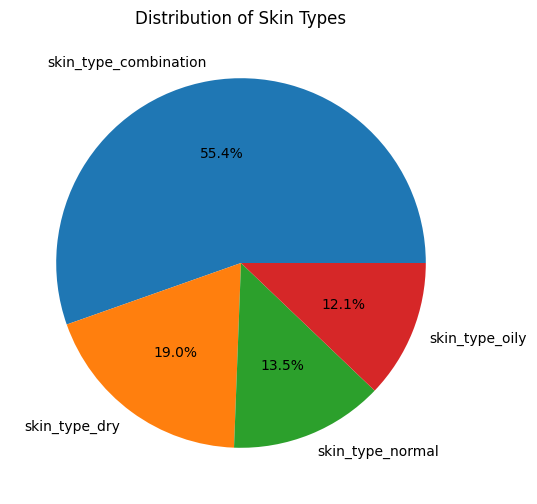

In [20]:
# Plotting the skin types distribution
plt.figure(figsize=(10, 6))
skin_type_cols = ['skin_type_combination', 'skin_type_dry', 'skin_type_normal', 'skin_type_oily']
skin_type_sums = final_df[skin_type_cols].sum()
plt.pie(skin_type_sums, labels=skin_type_cols, autopct='%1.1f%%')
plt.title('Distribution of Skin Types')
plt.show()

In [21]:
skin_type_sums = final_df[skin_type_cols].sum()
print(skin_type_sums)

skin_type_combination    435240.0
skin_type_dry            149246.0
skin_type_normal         105802.0
skin_type_oily            95333.0
dtype: float64


### Since that the skin type dataset has only 3 skin types (normal, dry and oily), and the products dataset has 4 skin types (combination, normal, dry and oily) there was a need to handel this difference so a dermatologist was contacted to see which is the closest skin type to the combination skin type and the answer of the dermatologist was the "Normal" skin type, the dermatologist also said that we can recommend the same products for both the "Normal" skin type  and the "Combination" skin type, so according to this information we can merge the "Combination" skin type and the "Normal" skin type under one category ("Normal").

In [22]:
# First lets take copy of the final_df to handle the skin types
test_merge_skin_types_df = final_df.copy()
test_merge_skin_types_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 785621 entries, 0 to 785620
Data columns (total 39 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   rating                             785621 non-null  int64  
 1   review_text                        785621 non-null  object 
 2   total_feedback_count               785621 non-null  int64  
 3   total_neg_feedback_count           785621 non-null  int64  
 4   total_pos_feedback_count           785621 non-null  int64  
 5   product_id                         785621 non-null  object 
 6   price_usd                          785621 non-null  float64
 7   product_name                       785621 non-null  object 
 8   ingredients                        785621 non-null  object 
 9   primary_category                   785621 non-null  object 
 10  secondary_category                 785621 non-null  object 
 11  processed_review                   7856

Skin Type Distribution after merging:
skin_type_dry       149246.0
skin_type_normal    541042.0
skin_type_oily       95333.0
dtype: float64

Percentages:
skin_type_dry       18.997201
skin_type_normal    68.868067
skin_type_oily      12.134732
dtype: float64 %


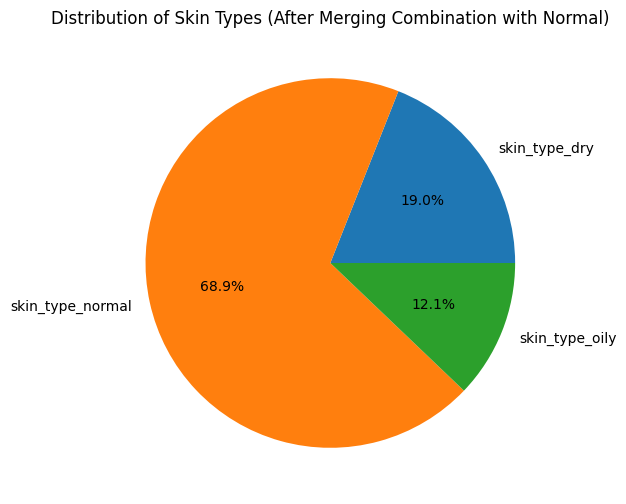

In [23]:
# Creating a new skin type columns where the combination is merged with  the normal
test_merge_skin_types_df['skin_type_normal'] = test_merge_skin_types_df.apply(
    lambda row: 1 if row['skin_type_combination'] == 1 or row['skin_type_normal'] == 1 else 0,
    axis=1
)

# Dropping the combination column since it's now merged with the normal skin type
test_merge_skin_types_df.drop('skin_type_combination', axis=1, inplace=True)

# Verifying the changes by showing the  distribution
skin_type_cols = ['skin_type_dry', 'skin_type_normal', 'skin_type_oily']
skin_type_sums = test_merge_skin_types_df[skin_type_cols].sum()

# Printing the new counts
print("Skin Type Distribution after merging:")
print(skin_type_sums)
print("\nPercentages:")
print((skin_type_sums / len(test_merge_skin_types_df)) * 100, "%")

# Visualizing the new distribution
plt.figure(figsize=(10, 6))
plt.pie(skin_type_sums, labels=skin_type_cols, autopct='%1.1f%%')
plt.title('Distribution of Skin Types (After Merging Combination with Normal)')
plt.show()

In [24]:
final_recommendation_df = test_merge_skin_types_df.copy()
final_recommendation_df.columns

Index(['rating', 'review_text', 'total_feedback_count',
       'total_neg_feedback_count', 'total_pos_feedback_count', 'product_id',
       'price_usd', 'product_name', 'ingredients', 'primary_category',
       'secondary_category', 'processed_review', 'review_length',
       'processed_ingredients', 'ingredient_count', 'has__glycerin_',
       'has__phenoxyethanol_', 'has__butylene_glycol_', 'has__propanediol_',
       'has__tocopherol_', 'has__citric_acid_', 'has__ethylhexylglycerin_',
       'has__sodium_hyaluronate_', 'has__xanthan_gum_',
       'has__sodium_benzoate_', 'has__caprylyl_glycol_',
       'has__potassium_sorbate_', 'has__polysorbate_',
       'has__sodium_hydroxide_', 'has__capryliccapric_triglyceride_',
       'has__tocopheryl_acetate_', 'has__squalane_', 'has__dimethicone_',
       'has__pentylene_glycol_', 'has_water_', 'skin_type_dry',
       'skin_type_normal', 'skin_type_oily'],
      dtype='object')

In [25]:
print(final_recommendation_df.shape)
final_recommendation_df.head()

(785621, 38)


,rating,review_text,total_feedback_count,total_neg_feedback_count,total_pos_feedback_count,product_id,price_usd,product_name,ingredients,primary_category,secondary_category,processed_review,review_length,processed_ingredients,ingredient_count,has__glycerin_,has__phenoxyethanol_,has__butylene_glycol_,has__propanediol_,has__tocopherol_,has__citric_acid_,has__ethylhexylglycerin_,has__sodium_hyaluronate_,has__xanthan_gum_,has__sodium_benzoate_,has__caprylyl_glycol_,has__potassium_sorbate_,has__polysorbate_,has__sodium_hydroxide_,has__capryliccapric_triglyceride_,has__tocopheryl_acetate_,has__squalane_,has__dimethicone_,has__pentylene_glycol_,has_water_,skin_type_dry,skin_type_normal,skin_type_oily
0,5,I use this with the Nudestix “Citrus Clean Bal...,2,0,2,P504322,19.0,Gentle Hydra-Gel Face Cleanser,"['Water (Aqua), Dipropylene Glycol, Peg-6 Capr...",Skincare,Cleansers,use nudestix citrus clean balm makeup melt dou...,283,water | dipropylene glycol | peg capryliccapri...,22,1,0,1,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,1.0,0,0.0
1,5,My review title says it all! I get so excited ...,0,0,0,P420652,24.0,Lip Sleeping Mask Intense Hydration with Vitam...,"['Diisostearyl Malate, Hydrogenated Polyisobut...",Skincare,Lip Balms & Treatments,review title say get excited get bed apply lip...,178,diisostearyl malate | hydrogenated polyisobute...,34,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1.0,0,0.0
2,5,I’ve always loved this formula for a long time...,0,0,0,P420652,24.0,Lip Sleeping Mask Intense Hydration with Vitam...,"['Diisostearyl Malate, Hydrogenated Polyisobut...",Skincare,Lip Balms & Treatments,always loved formula long time honestly even u...,152,diisostearyl malate | hydrogenated polyisobute...,34,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0.0,1,0.0
3,5,"If you have dry cracked lips, this is a must h...",0,0,0,P420652,24.0,Lip Sleeping Mask Intense Hydration with Vitam...,"['Diisostearyl Malate, Hydrogenated Polyisobut...",Skincare,Lip Balms & Treatments,dry cracked lip must week use learned always b...,108,diisostearyl malate | hydrogenated polyisobute...,34,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0.0,1,0.0
4,4,The scent isn’t my favourite but it works grea...,1,0,1,P420652,24.0,Lip Sleeping Mask Intense Hydration with Vitam...,"['Diisostearyl Malate, Hydrogenated Polyisobut...",Skincare,Lip Balms & Treatments,scent favourite work great put every night go ...,117,diisostearyl malate | hydrogenated polyisobute...,34,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0.0,1,0.0


In [26]:
final_recommendation_df.to_csv("final_recommendation_df_input_bert.csv", index=False)

# BERT Model (Before Balancing the data)

### This code will:
1. Load a pre-trained BERT model specifically trained for sentiment analysis
2. Process your reviews and assign sentiment scores
3. Convert scores to both numerical (1-5) and categorical (Negative/Neutral/Positive) formats also


In [27]:
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm
from sklearn.metrics import classification_report, accuracy_score
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.nn.functional import softmax

In [28]:
# Checking the GPU availability and set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [29]:
# Loading Pre-trained BERT Model
print("Loading pre-trained BERT tokenizer and model...")
tokenizer = AutoTokenizer.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')
model = AutoModelForSequenceClassification.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')
model.to(device)

Loading pre-trained BERT tokenizer and model...


tokenizer_config.json:   0%|          | 0.00/39.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/953 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/872k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/669M [00:00<?, ?B/s]

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(105879, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1

In [30]:
# Defining the Sentiment Prediction Function
def get_sentiment(text, tokenizer, model):
    """
    Returns softmax probability distribution over sentiment classes (1 to 5).
    Input text is truncated to 512 tokens (BERT's max).
    """
    encoded = tokenizer(text, truncation=True, max_length=512, return_tensors='pt').to(device)
    with torch.no_grad():
        output = model(**encoded)
    scores = softmax(output.logits, dim=1)
    return scores.cpu().numpy()[0]

In [31]:
# Data Preprocessing
final_recommendation_df = final_recommendation_df.dropna(subset=['processed_review']).copy()
final_recommendation_df['processed_review'] = final_recommendation_df['processed_review'].astype(str)

In [32]:
# Batch Sentiment Prediction
print("Predicting sentiment scores in batches...")
batch_size = 32 
sentiments = []

for i in tqdm(range(0, len(final_recommendation_df), batch_size)):
    batch_texts = final_recommendation_df['processed_review'].iloc[i:i+batch_size].tolist()
    batch_scores = [get_sentiment(text, tokenizer, model) for text in batch_texts]
    sentiments.extend(batch_scores)

Predicting sentiment scores in batches...


100%|██████████| 24551/24551 [1:43:23<00:00,  3.96it/s]


In [33]:
# Postprocessing: Convert to Numerical and Categorical Sentiments
final_recommendation_df['sentiment_score'] = [np.argmax(score) + 1 for score in sentiments]

# Converting them to binary sentiment category (Negative: 1–3, Positive: 4–5)
def map_sentiment_category(score):
    return 'Negative' if score <= 3 else 'Positive'

final_recommendation_df['sentiment_category'] = final_recommendation_df['sentiment_score'].apply(map_sentiment_category)

def map_rating_category(rating):
    return 'Negative' if rating <= 3 else 'Positive'

final_recommendation_df['true_category'] = final_recommendation_df['rating'].apply(map_rating_category)

In [34]:
# Evaluation Metrics
y_true = final_recommendation_df['true_category']
y_pred = final_recommendation_df['sentiment_category']

print("\nClassification Report:")
print(classification_report(y_true, y_pred, digits=3))

accuracy = accuracy_score(y_true, y_pred)
print(f"Accuracy: {accuracy:.3f}")


Classification Report:
              precision    recall  f1-score   support

    Negative      0.391     0.789     0.523    139205
    Positive      0.942     0.735     0.826    646407

    accuracy                          0.745    785612
   macro avg      0.666     0.762     0.674    785612
weighted avg      0.844     0.745     0.772    785612

Accuracy: 0.745


In [35]:
# The Correlation Between the Predicted Score and the Actual Ratings
correlation = final_recommendation_df['sentiment_score'].corr(final_recommendation_df['rating'])
print(f"Correlation between sentiment score and actual rating: {correlation:.2f}")

Correlation between sentiment score and actual rating: 0.45


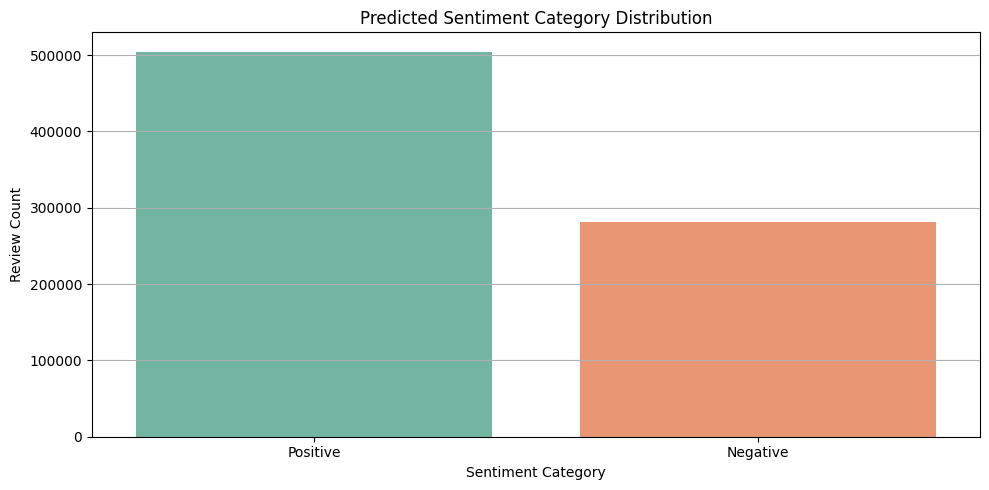

In [36]:
# Visualization: Sentiment Distribution
plt.figure(figsize=(10, 5))
sns.countplot(data=final_recommendation_df, x='sentiment_category', palette='Set2')
plt.title('Predicted Sentiment Category Distribution')
plt.xlabel('Sentiment Category')
plt.ylabel('Review Count')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [40]:
# Save the processed dataframe
final_recommendation_df.to_csv('final_recommendation_df_after_bert.csv', index=False)

In [41]:
final_recommendation_df['sentiment_score'].unique()

array([5, 1, 3, 4, 2])

In [43]:
final_recommendation_df['rating'].unique()

array([5, 4, 2, 1, 3])

# BERT With Balanced Data (After Oversampling)

In [45]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.nn.functional import softmax
import torch
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

In [46]:
final_recommendation_df=pd.read_csv("/kaggle/working/final_recommendation_df_input_bert.csv")
final_recommendation_df.columns

<ipython-input-46-100766f234df>:1: DtypeWarning: Columns (0,1,4,5,6,7,8,9,10,11,12,13) have mixed types. Specify dtype option on import or set low_memory=False.
  final_recommendation_df=pd.read_csv("/kaggle/working/final_recommendation_df_input_bert.csv")


Index(['rating', 'review_text', 'total_feedback_count',
       'total_neg_feedback_count', 'total_pos_feedback_count', 'product_id',
       'price_usd', 'product_name', 'ingredients', 'primary_category',
       'secondary_category', 'processed_review', 'review_length',
       'processed_ingredients', 'ingredient_count', 'has__glycerin_',
       'has__phenoxyethanol_', 'has__butylene_glycol_', 'has__propanediol_',
       'has__tocopherol_', 'has__citric_acid_', 'has__ethylhexylglycerin_',
       'has__sodium_hyaluronate_', 'has__xanthan_gum_',
       'has__sodium_benzoate_', 'has__caprylyl_glycol_',
       'has__potassium_sorbate_', 'has__polysorbate_',
       'has__sodium_hydroxide_', 'has__capryliccapric_triglyceride_',
       'has__tocopheryl_acetate_', 'has__squalane_', 'has__dimethicone_',
       'has__pentylene_glycol_', 'has_water_', 'skin_type_dry',
       'skin_type_normal', 'skin_type_oily'],
      dtype='object')

In [47]:
# Checking for the GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [48]:
# Loading the pre-trained multilingual BERT sentiment model
print("Loading model and tokenizer...")
tokenizer = AutoTokenizer.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')
model = AutoModelForSequenceClassification.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')
model.to(device)
model.eval()

Loading model and tokenizer...


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(105879, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1

In [51]:
# Preprocessing the data before the BERT model training
# Drop NaN reviews and convert to string
df = final_recommendation_df.dropna(subset=['processed_review', 'rating']).copy()
df['processed_review'] = df['processed_review'].astype(str)

# Converting the ratings to numeric (in case they are strings)
df['rating'] = pd.to_numeric(df['rating'], errors='coerce')

# Drop rows where rating could not be converted
df = df.dropna(subset=['rating']).copy()
df['rating'] = df['rating'].astype(int)

# Converting the ratings to binary labels:
# Ratings 1–3 → Negative (label 0), Ratings 4–5 → Positive (label 1)
def convert_to_binary_label(rating):
    return 0 if rating <= 3 else 1

df['sentiment_label'] = df['rating'].apply(convert_to_binary_label)


In [50]:
print(df['rating'].dtype)

object


# Balancing the data

In [52]:
# STEP 2: Oversampling the Negative Classes by Duplication
def oversample_minority_class(df, label_col='sentiment_label'):
    class_counts = df[label_col].value_counts()
    max_count = class_counts.max()
    dfs = []
    for label in class_counts.index:
        subset = df[df[label_col] == label]
        if len(subset) < max_count:
            repeat_times = int(np.ceil(max_count / len(subset)))
            oversampled = pd.concat([subset] * repeat_times, ignore_index=True).sample(max_count, random_state=42)
            dfs.append(oversampled)
        else:
            dfs.append(subset.sample(max_count, random_state=42))
    return pd.concat(dfs).sample(frac=1, random_state=42).reset_index(drop=True)

In [53]:
print("Balancing the dataset...")
balanced_df = oversample_minority_class(df)

Balancing the dataset...


In [54]:
def get_sentiment_scores(texts, tokenizer, model, device, batch_size=32):
    all_scores = []

    for i in tqdm(range(0, len(texts), batch_size), desc="Processing reviews"):
        batch = texts[i:i+batch_size]
        encoded = tokenizer(batch, truncation=True, padding=True, max_length=512, return_tensors='pt')
        encoded = {k: v.to(device) for k, v in encoded.items()}

        with torch.no_grad():
            outputs = model(**encoded)
            probs = softmax(outputs.logits, dim=1)
            scores = probs.cpu().numpy()
            all_scores.extend(scores)

    return np.array(all_scores)

In [56]:
print("Predicting sentiment scores using BERT...")
texts = balanced_df['processed_review'].tolist()
scores = get_sentiment_scores(texts, tokenizer, model, device)

# Convert softmax scores (5-class) to sentiment score (1 to 5)
predicted_scores = np.argmax(scores, axis=1) + 1 

# Maping the predicted score to the sentiment labels (+ve/-ve)
def score_to_sentiment_label(score):
    return 0 if score <= 3 else 1

balanced_df['predicted_sentiment_label'] = [score_to_sentiment_label(s) for s in predicted_scores]

Predicting sentiment scores using BERT...


Processing reviews: 100%|██████████| 40392/40392 [1:21:30<00:00,  8.26it/s]


In [57]:
# Classification Report
y_true = balanced_df['sentiment_label']
y_pred = balanced_df['predicted_sentiment_label']

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=['Negative', 'Positive']))
print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")


Classification Report:
              precision    recall  f1-score   support

    Negative       0.75      0.79      0.77    646257
    Positive       0.78      0.73      0.76    646257

    accuracy                           0.76   1292514
   macro avg       0.76      0.76      0.76   1292514
weighted avg       0.76      0.76      0.76   1292514

Accuracy: 0.7619


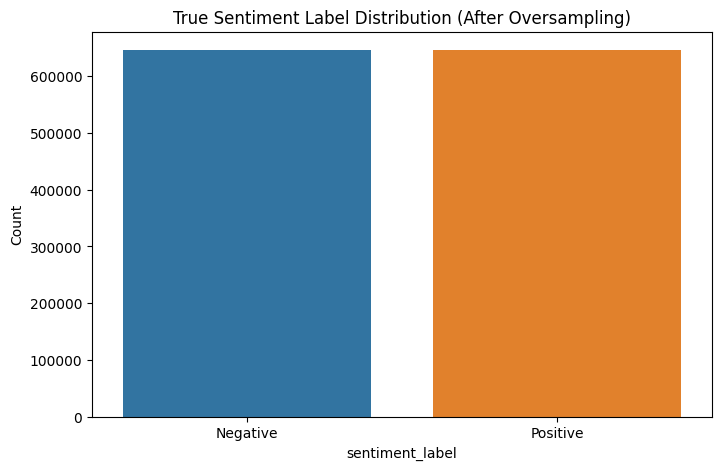

In [58]:
# Distribution of true sentiment labels
plt.figure(figsize=(8, 5))
sns.countplot(data=balanced_df, x='sentiment_label')
plt.title('True Sentiment Label Distribution (After Oversampling)')
plt.xticks([0, 1], ['Negative', 'Positive'])
plt.ylabel('Count')
plt.show()

In [60]:
# Correlation between predicted sentiment score (1-5) and actual rating
correlation = balanced_df['predicted_score'].corr(balanced_df['rating'])
print(f"Correlation between predicted sentiment score and actual rating: {correlation:.2f}")

Correlation between predicted sentiment score and actual rating: 0.57


In [61]:
# Save the processed dataframe
balanced_df.to_csv('balanced_df_after_bert.csv', index=False)

In [62]:
# ROC-AUC Score
binary_probs = np.sum(scores[:, 3:], axis=1)  

roc_auc = roc_auc_score(y_true, binary_probs)
print(f"\nROC-AUC Score: {roc_auc:.4f}")


ROC-AUC Score: 0.8402


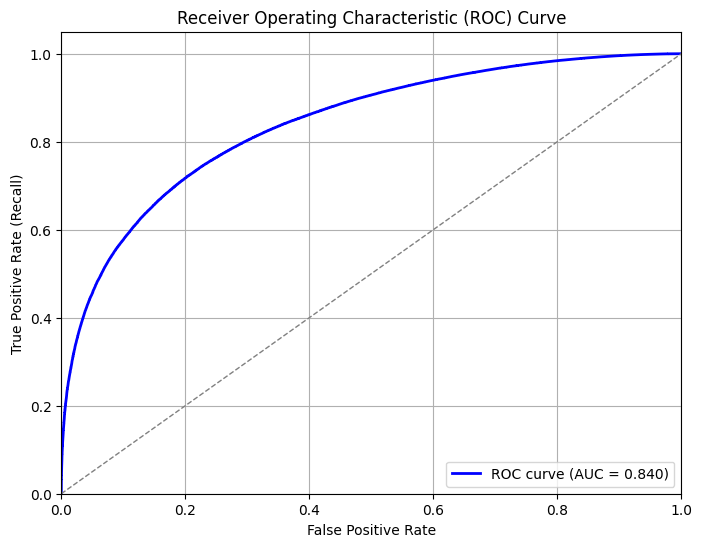

In [63]:
# ROC curve and ROC area
fpr, tpr, thresholds = roc_curve(y_true, binary_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# **Conclusion**
# The  BERT Model performance has enhanced after balancing the dataset